This notebook lays out instructions for performing WCTE timing calibration using data collected with the standalone DAQ (i.e. using the parquet file format). Dean has written a script that takes in the "_led.parquet" and "_waveforms.parquet" files and produces a dictionary with 4 primary keys: the mPMT card ID of the mPMT that is firing its LED, the LED number that is being fired, the coarse counter time that the LED fired, and the mPMTs for which we are collecting data. This last key contains all of the timing information for each mPMT (and each PMT) for the event. Note that this dictionary uses no position information of the mPMTs, PMTs, or LEDs - the mapping to position information is done later. To produce this dictionary, open the "process_parquet.py" file and input the run you're wanting to process (make sure to also change the folder variable in the file). Run the file with in the terminal with python3 process_parquet.py. You should now have a dictionary created in your file path that looks like the following...

In [1]:
import sys
sys.path.insert(0, "../../Geometry")
sys.path.insert(0, "../TimeCal")

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from Geometry.WCD import WCD
from wcte_led_test_v2 import *
from TC_Simulator import *
from TC_Data import *
from TC_Calibrator import *
from TC_Multilaterator import *

folder = "/Users/jakobrimmer/Documents/TRIUMF/WCTE/analysis/time_cal/wcte_test/mPMT_led_events/18_11_2024/"

#These are the runs we are going to use for this demonstration...disregard the different name formats...
#It's all good LED data from November 18th
runs = ['20241118180921','20241118151949','20241118160504',
        'soft_single_20241118144519','soft_single_20241118140152',
       'soft_single_20241118150355', 'soft_single_20241118152848','soft_single_20241118154904']

In [2]:
# Import the dictionary files into a list of entries
data_all = []

for run in runs:
    with open(folder+run+"_pq.dict", 'rb') as f:
        data_all.append(pickle.load(f))

In [3]:
# Check the number of LED flashes in the first file
len(data_all[0])

5000

In [4]:
# Check the keys in the first flash of the first file
data_all[0][0].keys()

dict_keys(['card_id', 'led_no', 'coarse', 'mpmts'])

In [5]:
# Have a look at the information collected from the first flash
data_all[0][0]

{'card_id': 77,
 'led_no': 1,
 'coarse': 730227472,
 'mpmts': {6: [{'chan': 0,
    't': 63.09636666666667,
    'amp': np.float64(1.8885741265344667),
    'baseline': 0.0,
    'coarse': 730227621},
   {'chan': 1,
    't': 154.61195419664267,
    'amp': np.float64(145.89235127478753),
    'baseline': 0.6666666666666666,
    'coarse': 730227621},
   {'chan': 2,
    't': np.float64(79.1797),
    'amp': np.float64(1.41643059490085),
    'baseline': 0.0,
    'coarse': 730227621},
   {'chan': 3,
    't': 80.76303333333333,
    'amp': np.float64(1.41643059490085),
    'baseline': -1.0,
    'coarse': 730227621},
   {'chan': 4,
    't': 127.51303333333333,
    'amp': np.float64(2.3607176581680833),
    'baseline': 0.3333333333333333,
    'coarse': 730227621},
   {'chan': 5,
    't': np.float64(116.76303333333333),
    'amp': np.float64(2.8328611898017),
    'baseline': 0.0,
    'coarse': 730227621},
   {'chan': 6,
    't': 209.89636666666667,
    'amp': np.float64(2.3607176581680833),
    'basel

We can now input this data into the timing calibration code. However, the code right now is set up to only take one file at a time, and outputs the timing information in a list format that needs to be then inputted into Dean's TimeCal code. This is because I had to re-write a lot of the code to deal with this new data format, and so it is probably easier for the time being to just run things in pieces in a python notebook until we have stable time calibration code. We therefore have to loop through and run the code on each file individually, and then loop through the resulting list and give Dean's code the relevant quantities (transmitting mPMT, LED position, receiving mPMT, receiving PMT, dt (measured transit time), t_sig (sigma on the transit time)).

In [6]:
# Call the get_calibration_constants function, which returns 
# [transmitting mPMT, LED position, receiving mPMT, receiving PMT, dt (fitted transit time), t_sig (sigma on the transit time)]
tc_data = []
run = 0 # Don't worry about the run number right now - it's not yet used in the code
for i in range(len(data_all)):
    tc_data.append(get_calibration_constants(run,data_all[i]))

mPMT slot that is firing: 23, with LED position: 0
mPMT slot that is firing: 68, with LED position: 2
mPMT slot that is firing: 6, with LED position: 0
mPMT slot that is firing: 4, with LED position: 1
mPMT slot that is firing: 49, with LED position: 0
mPMT slot that is firing: 60, with LED position: 2
mPMT slot that is firing: 21, with LED position: 1
mPMT slot that is firing: 42, with LED position: 0


/Users/jakobrimmer/Documents/TRIUMF/WCTE/analysis/time_cal/wcte_test/wcte_led_test_v2.py:670: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(Gauss, bin_centers, fit_hist, p0=[amp0, mean, std])


We can now perform the timing calibration. Import the geometry package and create an instance of Dean's calibrator...

In [7]:
from Geometry.Device import Device
my_hall = Device.open_file('wcte_bldg157.geo')
my_wcte = my_hall.wcds[0]
my_wcte.mpmts[0].pmts[0].prop_true['delay']

tc_led_data = TC_Data(str(run))

Now loop through and give the data to the calibrator...

In [8]:
for i in range(len(tc_data)):
    for j in range(len(tc_data[i])):
        tc_led_data.set(tc_data[i][j][0],tc_data[i][j][1],tc_data[i][j][2],tc_data[i][j][3],tc_data[i][j][4],tc_data[i][j][5])
    

Now perform the calibration. Note that here is where you set the reference mPMT (I've chosen mPMT 49 here, with an offset of 0, for convenience).

In [9]:
wcte_calib = TC_Calibrator(my_wcte) 
wcte_calib.assign_data(tc_led_data)
wcte_calib.set_reference_mpmt(49,0,0.1) # Set the reference mPMT
wcte_calib.set_priors(0.,10.,0.,10.,epsilon_apply=False, alpha_apply=True) #Set the priors
#design or est as args
#chi2, n_dof =wcte_calib.calibrate(return_chisqs=True,place_info='est')
chi2, n_dof, chisqs, devs_led, dists_led =wcte_calib.calibrate(return_chisqs = True) # Do the calibration

Let's now extract the various timing constants...

In [10]:
# compare the uncalibrated delays with the calibrated delays

estimated_clock_offsets = []
for i in range(len(my_wcte.mpmts)):
    try:
        estimated_clock_offsets.append(my_wcte.mpmts[i].prop_est['clock_offset'])
    except:
        continue


estimated_led_delays = []
for mpmt in my_wcte.mpmts:
    for il, led in enumerate(mpmt.leds):
        if il < 3: # At most 3 flashing LEDs per PMT
            try:
                estimated_led_delays.append(led.prop_est['delay'])
            except:
                continue



estimated_pmt_delays = []

for mpmt in my_wcte.mpmts:
    for pmt in mpmt.pmts:
        try:
            estimated_pmt_delays.append(pmt.prop_est['delay'])
        except:
            continue
        

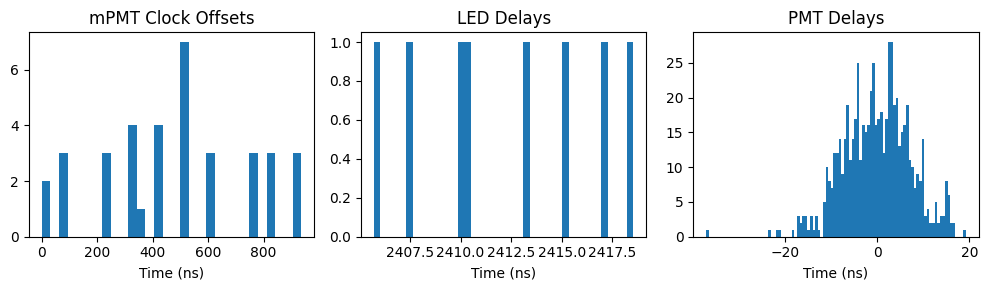

In [11]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].hist(estimated_clock_offsets,bins=30)
ax[1].hist(estimated_led_delays,bins=40)
ax[2].hist(estimated_pmt_delays,bins=100)


ax[0].set_title('mPMT Clock Offsets')
ax[1].set_title('LED Delays')
ax[2].set_title('PMT Delays')

ax[0].set_xlabel('Time (ns)')
ax[1].set_xlabel('Time (ns)')
ax[2].set_xlabel('Time (ns)')

#ax[2].set_xlim(-150,100)
fig.tight_layout()
#plt.show()

Note here that the large variation in mPMT clock offsets is from the daisy chaining in the MCCs. Note also that the large LED delay times are from the fact that the LEDs do not fire until about 2.4 microseconds after the command is given. Let's have a look at the deviations between the estimated and true arrival times (this is the devs_led variable that is returned by running Dean's calibration code).

In [12]:
devs = []
dists = []
for key in devs_led:
    devs.append(devs_led[key])
    dists.append(dists_led[key])


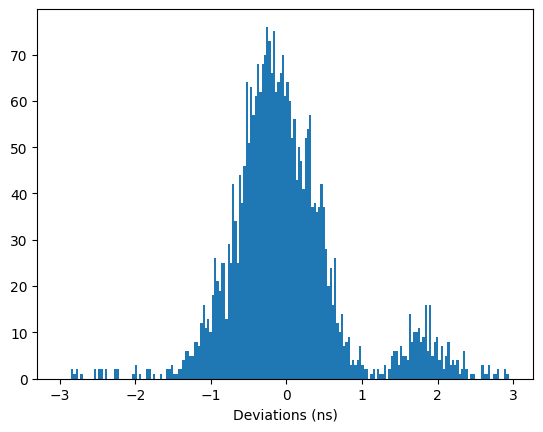

In [13]:
plt.hist(devs,bins=np.arange(-3,3,0.03))
plt.xlabel('Deviations (ns)')
plt.show()

This is a fairly narrow distribution, but not as narrow as Dean has produced - so he must have done additional cuts to his data that I have not implemented here (I think he has expluded other PMTs from the calibration). Either way, the calibration works and we should continue to optimize it. Right now, the code is set up so that running get_calibration_constants() does not produce plots because this significantly slows the process. There is another function in the wcte_led_test_v2.py file called plot_only(run, data, plot_double_peaks, plot_all). Here, run and data are the same as before, but "plot_double_peaks" and "plot_all" are booleans that allow someone to save plots of the PMTs identified as having double peaks, and all active PMTs, respectively.